<a href="https://colab.research.google.com/github/thecalebe00/Portfolio-Optimization/blob/main/Portfolio_Optimization_FGV_Quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Otimização de Portfolio e Backtesting** - Projeto FGV Quant

Este projeto tem por objetivo a otimização de carteiras de ações através de minimização de riscos (Sharpe Ratio), utilizando conceitos de Fronteira Eficiente de Markowitz e demais ferramentas.

Autor: **Calebe Soares**

In [ ]:
#Importação de bibliotecas
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
!pip install yfinance #biblioteca para importação dos dados das ações
import yfinance as yf
!pip install pyportfolioopt #biblioteca a ser utilzada para otimização da carteira

## Seleção de ativos e plotagem do retorno por cada ação da carteira

Digite quais são os ativos que vão compor sua carteira: tasa4,vale3,wege3,hgtx3,bpac11
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


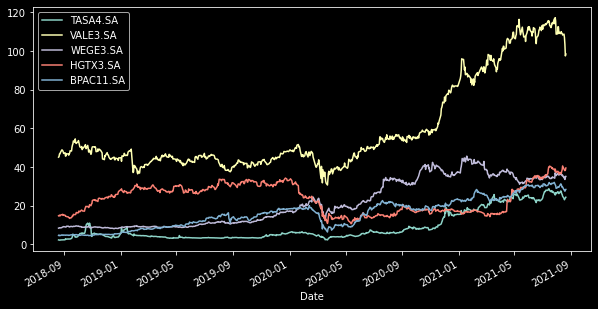

In [57]:
#Seleção de ativos
ativos = input("Digite quais são os ativos que vão compor sua carteira: ").upper().split(",")
ativos = [ticker + ".SA" for ticker in ativos]

#Com as devidas bibliotecas instaladas, agora iremos fazer a composição da carteira pelas ações escolhidas
carteira = pd.DataFrame()
for i in ativos:
  carteira[i] = yf.download(i,period="3y")['Adj Close']

#Visualização dos retornos das ações
plt.style.use('dark_background')
carteira.plot(figsize=(10,5))

## Cálculos do retorno da carteira e a matriz de covariância

In [58]:
#Para a realização da fronteira eficiente, é necessário a realização do retorno esperado e da matriz de covariação
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
er = mean_historical_return(carteira) #Retorno esperado da carteira
sd = CovarianceShrinkage(carteira).ledoit_wolf() #Matriz de covariância
sd

,TASA4.SA,VALE3.SA,WEGE3.SA,HGTX3.SA,BPAC11.SA
TASA4.SA,0.963539,0.064697,0.045714,0.094357,0.070611
VALE3.SA,0.064697,0.207546,0.050899,0.068536,0.093683
WEGE3.SA,0.045714,0.050899,0.187901,0.079036,0.088275
HGTX3.SA,0.094357,0.068536,0.079036,0.336868,0.140636
BPAC11.SA,0.070611,0.093683,0.088275,0.140636,0.325056


## Alocação da carteira nos ativos de acordo a maximização do Índice de Sharpe  
 Visão geral do retorno esperado da carteira, volatilidade e Sharpe Ratio do portfolio

In [59]:
#Com a matriz de covariação e o retorno esperado das ações da carteira, agora calculamos a porcentagemd e alocação em cada posição da carteira
taxa_livre_de_risco = float(input("Qual a taxa livre de risco? *Digite usando o separador decimal usando o ponto* "))
taxa_livre_de_risco = taxa_livre_de_risco/100
from pypfopt.efficient_frontier import EfficientFrontier
ef = EfficientFrontier(er,sd)
composicao = ef.max_sharpe(risk_free_rate=taxa_livre_de_risco)

#Visão geral
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

Qual a taxa livre de risco? *Digite usando o separador decimal usando o ponto* 5.25
OrderedDict([('TASA4.SA', 0.21353), ('VALE3.SA', 0.0), ('WEGE3.SA', 0.43009), ('HGTX3.SA', 0.0), ('BPAC11.SA', 0.35638)])
Expected annual return: 84.0%
Annual volatility: 40.8%
Sharpe Ratio: 1.93


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:412: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  UserWarning,


(0.8399819904562199, 0.4076485406956445, 1.9317669802335042)

In [60]:
#Como houveram posições com peso igual a 0, houve o rebalanceamento de modo a ponderar melhor as posições da carteira
from pypfopt import objective_functions

ef = EfficientFrontier(er, sd)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
w = ef.max_sharpe()
ef.clean_weights()

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:253: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('TASA4.SA', 0.24627),
             ('VALE3.SA', 0.0053),
             ('WEGE3.SA', 0.37803),
             ('HGTX3.SA', 0.0),
             ('BPAC11.SA', 0.3704)])

## Quantidade de ações a serem compradas de acordo com o patrimônio do portfolio

In [61]:
#Quantidade de ações a serem compradas de acordo com o valor de seu portfolio
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
portfolio_value = float(input("Qual o valor do seu portfolio? * Digite apenas o numero, sem vírgulas e pontos *"))
latest_prices = get_latest_prices(carteira)
da = DiscreteAllocation(w, latest_prices, portfolio_value)
allocation, leftover = da.lp_portfolio()
print(allocation)

Qual o valor do seu portfolio? * Digite apenas o numero, sem vírgulas e pontos *150000
{'TASA4.SA': 1514, 'VALE3.SA': 8, 'WEGE3.SA': 1614, 'BPAC11.SA': 1955}


## Plotagem da fronteria eficiente

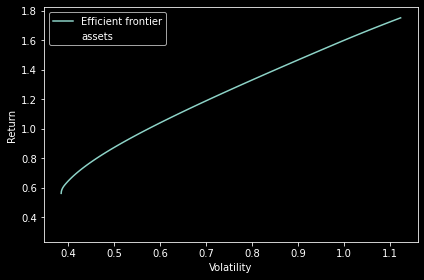

In [66]:
#Plotagem da Fronteira eficiente
from pypfopt import plotting
ef = EfficientFrontier(er, sd, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

## Fronteria eficiente com Índice de Sharpe maximizado e geração de portfolios aleatórios para a fronteira

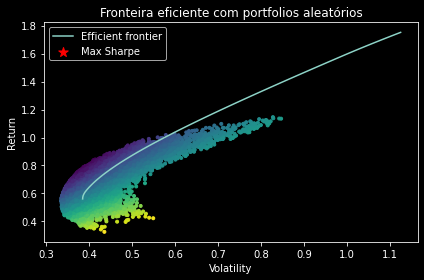

In [67]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Geração de portfolios aleatórios, para a composição da fronteira
n_samples = 10000
w = np.random.dirichlet(np.ones(len(er)), n_samples)
rets = w.dot(er)
stds = np.sqrt(np.diag(w @ sd @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Resultado
ax.set_title("Fronteira eficiente com portfolios aleatórios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

## Backtesting

In [ ]:
!pip install bt

In [68]:
import bt
rebalancing = bt.Strategy("Rebalanceamento",
                          [bt.algos.RunMonthly(run_on_end_of_period=True), 
                           bt.algos.SelectAll(), 
                           bt.algos.WeighSpecified(**composicao), 
                           bt.algos.Rebalance()]
                          )

buyhold = bt.Strategy("Buy & Hold",
                      [bt.algos.RunOnce(), 
                       bt.algos.SelectAll(), 
                       bt.algos.WeighSpecified(**composicao),
                       bt.algos.Rebalance()]
                      )

In [69]:
bt1 = bt.Backtest(rebalancing, carteira, initial_capital=portfolio_value)
bt2 = bt.Backtest(buyhold, carteira, initial_capital=portfolio_value)

In [70]:
results = bt.run(bt1, bt2)

/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/usr/local/lib/python3.7/dist-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [71]:
results.display()

Stat                 Rebalanceamento    Buy & Hold
-------------------  -----------------  ------------
Start                2018-08-19         2018-08-19
End                  2021-08-20         2021-08-20
Risk-free rate       0.00%              0.00%

Total Return         599.58%            523.55%
Daily Sharpe         1.75               1.55
Daily Sortino        2.75               2.42
CAGR                 91.11%             83.93%
Max Drawdown         -51.94%            -53.41%
Calmar Ratio         1.75               1.57

MTD                  -2.63%             -3.52%
3m                   3.48%              2.04%
6m                   0.52%              3.01%
YTD                  17.22%             21.53%
1Y                   66.48%             63.14%
3Y (ann.)            91.23%             84.03%
5Y (ann.)            -                  -
10Y (ann.)           -                  -
Since Incep. (ann.)  91.11%             83.93%

Daily Sharpe         1.75               1.55
Daily Sorti

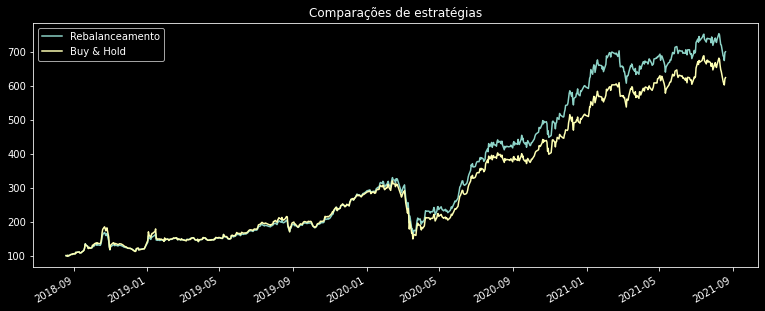

In [72]:
results.plot(title="Comparações de estratégias",figsize=(13,5))

In [73]:
results.get_transactions()

price  quantity
Date       Security                      
2018-08-20 BPAC11.SA   4.667668   11452.0
           TASA4.SA    2.300000   13925.0
           WEGE3.SA    8.390136    7689.0
2018-08-31 BPAC11.SA   4.805987     296.0
           TASA4.SA    2.340000     531.0
...                         ...       ...
2021-06-30 TASA4.SA   23.650000     443.0
           WEGE3.SA   33.540771    -191.0
2021-07-30 BPAC11.SA  28.983353     990.0
           TASA4.SA   26.150000    -624.0
           WEGE3.SA   35.551823    -347.0

[111 rows x 2 columns]

In [74]:
results.get_security_weights()

,TASA4.SA,WEGE3.SA,BPAC11.SA
2018-08-19,0.000000,0.000000,0.000000
2018-08-20,0.213517,0.430078,0.356361
2018-08-21,0.212630,0.439316,0.348009
2018-08-22,0.205915,0.436377,0.357665
2018-08-23,0.202440,0.445151,0.352364
...,...,...,...
2021-08-16,0.203003,0.434667,0.362299
2021-08-17,0.197793,0.440462,0.361714
2021-08-18,0.206260,0.433172,0.360537
2021-08-19,0.201867,0.438532,0.359571


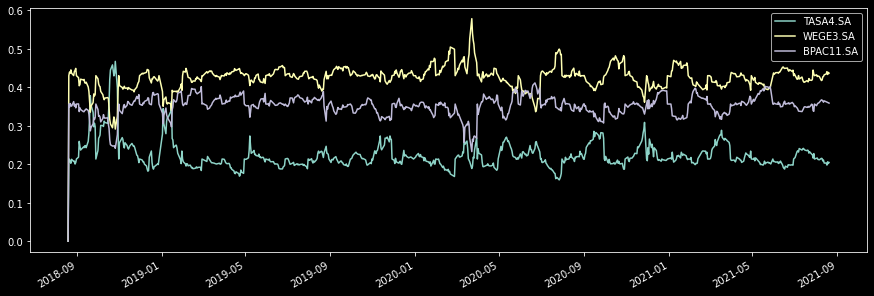

In [75]:
results.plot_security_weights()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

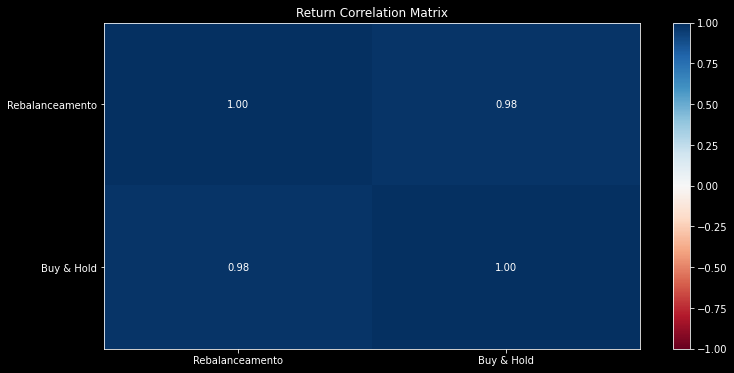

In [76]:
results.plot_correlation()

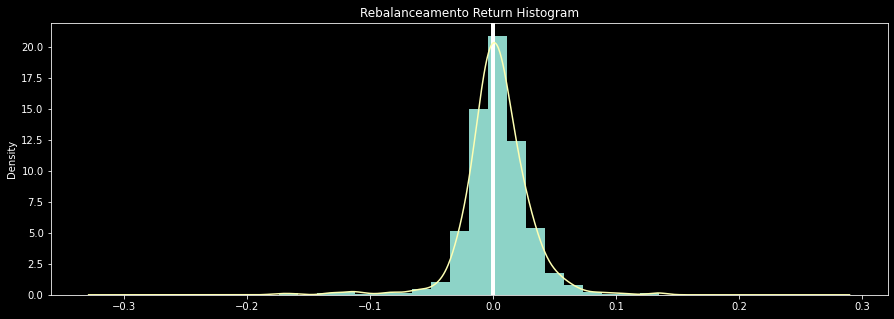

In [77]:
results.plot_histogram()